In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/suchan/study/파이널 프로젝트/contents_Watcha.csv")

In [43]:
df.isna().sum()

Unnamed: 0    0
title         0
reviews       0
dtype: int64

In [5]:
df.title.unique()

array(['우리들의 블루스', '파친코', '돼지의 왕', '그린마더스클럽', '사내 맞선', '스물다섯 스물하나',
       '시맨틱 에러', '소년비행', '악의 마음을 읽는 자들', '나의 아저씨', '소년심판', '비밀의 숲',
       '비밀의 숲 2', '멜로가 체질', '괴물', '모범택시', '미스터 션샤인', '트레이서 시즌 1',
       '트레이서 시즌 2', '이렇게 된 이상 청와대로 간다', '술꾼도시여자들', '라이프 온 마스', '블랙독',
       '해피니스', '태종 이방원', '도시남녀의 사랑법', '검색어를 입력하세요 WWW', '옷소매 붉은 끝동',
       '악의 꽃', '런 온', '손 the guest', '서른, 아홉', '슬기로운 의사생활',
       '슬기로운 의사생활 시즌 2', 'D.P.', '사랑의 불시착', '스토브리그', '왓쳐', '그림자 미녀',
       '동백꽃 필 무렵', '백일의 낭군님', '어느 날 우리 집 현관으로 멸망이 들어왔다', '카이로스',
       '보좌관 – 세상을 움직이는 사람들', '보좌관 2 - 세상을 움직이는 사람들', '기름진 멜로', '새빛남고 학생회',
       '좋좋소', '키마이라', '며느라기 시즌 1', '며느라기 2…ing', '김비서가 왜 그럴까', '부부의 세계',
       '그녀의 사생활', '로스쿨', '구경이', '무브 투 헤븐: 나는 유품정리사입니다', '마우스', '검법남녀',
       '검법남녀 시즌2', '엉클', '하늘에서 내리는 1억개의 별', '우수무당 가두심', '오징어 게임',
       '킹덤 시즌 1', '킹덤 시즌 2', 'SKY 캐슬', '호텔 델루나', '갯마을 차차차', '아는 와이프',
       '원 더 우먼', '보이스', '보이스2', '보이스3', '오월의 청춘', '이 구역의 미친 X', '라켓소년단',
       '언프레임드', '마녀식당으로 오세요', '연애미수',

# 필요 함수들

In [6]:
import re
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from konlpy.tag import Mecab, Okt
from tqdm import tqdm

In [49]:
mecab = Mecab()
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, a):
#         a = ','.join(a)
        word_tokens = self.tagger.pos(a)
        
        results = []
        for word,pos in word_tokens:
            if pos in ['NNG','NNP'] and len(word) > 1:
                results.append(word)

        return results

# 작업

In [50]:
reviews = df.reviews.to_list()
doc = ','.join(reviews)

In [47]:
reviews[:5]

['이 화려한 캐스팅 라인업을 보고 안 볼수가 있나.. ㄷㄷㄷ 게다가 노희경 극본..ㄷㄷㄷ\n\n바로 이거지... 눈과 귀를 홀리는 이 몰입도!\n심지어 짠내나는 차승원이라니..ㅋㅋ 너무 좋다!!',
 '침묵의 순간들이 더욱 처연하게 빛나는, 노희경 극본의 또 다른 경지.',
 '세상에..노희경 작가와 이 배우들이라면 어떤 스토리가 됐든 꼭 보고싶다..',
 '하 진짜 좋아하는 배우 전부 다 나오네…\n.\n한수의 위험한 생각이 뭔지 알 것 같아서 고통스럽다.',
 '사람 사는 거 특별할 거 없다지만, 저마다의 사정을 찬찬히 듣노라면 그것만큼 재미난 맛도 없다.']

In [41]:
custom_tokenizer = CustomTokenizer(Mecab())

In [18]:
# re_review = []
# for review in reviews:
#     tokens = custom_tokenizer(review)
#     for token in tokens:
#         if token:
#             re_review.append(token)

In [52]:
# ngram_range = (1,3)
# stop_words = (('드라마','\r', '\n', '\r\n', '\n\r'))

custom_tokenizer = CustomTokenizer(Mecab())
# custom_tokenizer(doc)

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=10, min_df=2, max_features=10000).fit(reviews)
candidates = tfidf.get_feature_names_out()

In [53]:
len(candidates)

10000

# 임베딩

In [54]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("jhgan/ko-sroberta-multitask")

doc_embedding = model.encode(doc)
candidate_embeddings = model.encode(candidates)

In [55]:
candidate_embeddings.shape, doc_embedding.shape

((10000, 768), (768,))

# 코사인 유사도 연구(건너뛰어도 됨)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = len(candidates)

# 문서와 키워드간 유사도
distances = cosine_similarity(candidate_embeddings,doc_embedding)

# 키워드와 키워드간 유사도
distances_candidates = cosine_similarity(candidate_embeddings)

In [31]:
distances.shape, distances_candidates.shape, len(candidates) # candidates[index]

((10000, 10069), (10000, 10000), 10000)

In [32]:
word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
word_distances = cosine_similarity(candidate_embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def nonmmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        # 후보 키워드들의 문서유사도 값
        candidate_similarities = word_doc_distances[candidates_idx, :]
        # 후보 키워드와 가장 유사한 키워드
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords

In [133]:
keywords_idx = [7,87,92]
candidates_idx = [1,2,13,734,25,6]
candidate_similarities = word_doc_distances[candidates_idx, :]
candidate_similarities, candidate_similarities.shape # 후보키워드의 문서간유사도 벡터

(array([[-0.00580319],
        [-0.19800502],
        [-0.01558762],
        [-0.04957973],
        [ 0.0070086 ],
        [-0.16266811]], dtype=float32),
 (6, 1))

In [84]:
word_distances[candidates_idx][:,keywords_idx] # 후보키워드와 추출키워드의 유사도 벡터

array([[ 3.2524187e-02,  5.1560111e-02,  2.2039059e-01,  1.3396120e-01,
        -1.4120573e-04],
       [ 1.7449439e-01,  2.5826111e-01,  7.1534671e-02,  4.0343547e-01,
         3.3822396e-01],
       [ 1.4734800e-01,  1.9027355e-01,  2.1794148e-02,  3.4675038e-01,
         3.8210323e-01],
       [ 8.3954439e-02,  1.4057627e-01,  9.0675689e-02,  2.7277958e-01,
         3.1519559e-01]], dtype=float32)

In [ ]:
 target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1)
 target_similarities, target_similarities.shape # 후보키워드와 가장 유사한 추출 키워드 벡터

(array([0.30213898, 0.0680101 , 0.21618617], dtype=float32), (3,))

In [ ]:
mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
mmr,mmr.shape # mmr 계산을 통해 후보키워드에서 추출할 키워드 선정

(array([[-0.23494704],
        [-0.00761976],
        [-0.15552332]], dtype=float32), (3, 1))

In [149]:
for i in np.argsort(word_distances[candidates_idx][:,7])[:4]:
    print(candidates[i])

'lunar
'letting
'hotel
'letting go' 'unselfish


In [150]:
similar_keys = []
for i in keywords_idx:
    temp = []
    for j in np.argsort(word_distances[candidates_idx][:,i])[:4]:
        temp.append(candidates[j])
    similar_keys.append(temp)

In [151]:
similar_keys = []
for i in keywords_idx:
    temp = []
    for j in np.argsort(word_distances[candidates_idx][:,i])[:4]:
        temp.append(candidates[j])
    similar_keys.append(temp)
for i, keys in enumerate(keywords_idx):
    print(f'{candidates[keys]} : {similar_keys[i]}')


'lunar : ["'counters'", "'letting", "'letting go'", "'hotel"]
'lunar water' : ["'counters'", "'letting", "'letting go' 'unselfish", "'letting go'"]
'magical : ["'lunar", "'letting", "'hotel", "'letting go' 'unselfish"]


In [146]:
keywords_idx = [5,6,7]
word_distances[candidates_idx][:,keywords_idx]
np.sort(word_distances[candidates_idx][:,keywords_idx],axis=1)[:][:2]

array([[ 0.03252419,  0.05156011,  0.22039059],
       [ 0.17449439,  0.2582611 ,  0.07153467],
       [ 0.03501092,  0.09409308, -0.03085524],
       [ 0.11034438,  0.10579221,  0.29284918],
       [ 0.21789196,  0.09518174,  0.07269609],
       [ 0.79727995,  0.9999997 , -0.0317032 ]], dtype=float32)

In [105]:
candidates[7]

"'magical"

# 유사키워드 포함 추출하기

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
def mmrs(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        # 후보 키워드들의 문서유사도 값
        candidate_similarities = word_doc_distances[candidates_idx, :]
        # 후보 키워드와 가장 유사한 키워드
        target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
        
        # 추출키워드와 유사한 키워드 추가
    similar_keys = []
    for i in keywords_idx:
        temp = []
        for j in np.argsort(word_distances[candidates_idx][:,i])[:top_n]:
            temp.append(words[j])
        similar_keys.append(temp)

    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만

    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords, similar_keys

In [79]:
keywords, similar_keys = mmrs(doc_embedding,candidate_embeddings,candidates,top_n=6,diversity=0.7)

IndexError: index 2981 is out of bounds for axis 1 with size 171

In [14]:
print('Keywords and similar keys by cosine similarity')
for i in range(len(keywords)):
    print(f'{keywords[i]} : {similar_keys[i]}')

Keywords and similar keys by cosine similarity
excitement never stop : ['korean drama uncanny', 'wait see happen', 'korean drama silent', 'choose sacrificial lamb', 'etc set', 'rushed unfinished']
english teacher : ['never fully', 'action adventure', 'rest time', 'whole watch', 'fight evil spirit', 'edge seat episode']
sort buffy vampire : ['course main', 'cuz want', 'dad child', 'mean make', 'mean damn', "i'm say drama"]
noodle catch evil : ['man prove powerful', 'look however', 'time pick', 'couple main sideline', 'return season', 'inhabitant realm exist']
comatose teenager mun : ['sweet see', 'sweet romance', 'game spain actually', 'sweet home', 'sweet time', 'fictional city jungin']
drama disappoint : ['future character', 'koo walk ethic', 'jump jang', 'future exchange', 'young hong pyo', 'somewhat similar']


# 코사인 유사도 함수

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n-1):
        try:
            # 후보 키워드들의 문서유사도 값
            candidate_similarities = word_doc_distances[candidates_idx, :]
            # 후보 키워드와 가장 유사한 키워드
            target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

            mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
            mmr_idx = candidates_idx[np.argmax(mmr)]

            keywords_idx.append(mmr_idx)
            candidates_idx.remove(mmr_idx)
        except:
            break
    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords

In [57]:
doc_embedding.T.reshape(1,-1).shape

(1, 768)

In [60]:
keywords_vector, keywords = mmr(doc_embedding.T.reshape(1,-1),candidate_embeddings,candidates,top_n=500,diversity=0.6)

In [61]:
keywords_vector.shape

(500, 768)

In [62]:
keywords[:10]

['명연', '조두순', '팥빵', '울엄마', '소년원', '고레에다', '커피프린스', '낚시터', '나영석', '자살자']

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = keywords_vector

true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X.T)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = keywords # = candidates
for i in range(true_k):
    print("["),
    for ind in order_centroids[i, :20]:
        print(f'"{terms[ind]}"', end=",")
    print("],\n")

Top terms per cluster:
[
"조역","스카웃","명연","한상운","고진감래","전예","이준영","박병은","황정민","경준","미드나","사필귀정","안습","각이","감우성","섭이","차오","허구성","파배우","망드",],

[
"인트라넷","고레에다","하늘나라","발레리나","명랑만화","르포","만의","동백나무","강필구","초인종","신장","싸이월드","해유","망원경","설경구","모세","대지진","모노톤","저작권자","태양인",],

[
"자살자","남성혐오","발기부전","스윙걸즈","테슬라","간디도","소년원","커피프린스","불완전성","고자라니","만병통치약","퀴즈쇼","무색무취","심리치료","경비견","조두순","엘사","호주","핵전쟁","구석기",],



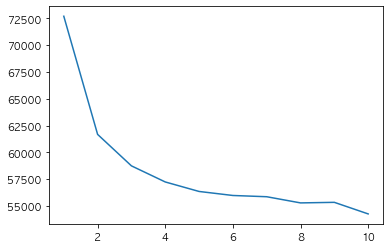

In [68]:
x = list(range(1,11))
y = []
for i in x:
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    model.fit(X.T)
    y.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(x,y,label='linear')
plt.show();